In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt

from pygmo import *

%matplotlib inline

In [2]:
lst = [0.1, 10.0, 12.0, 600.0, 50.0, 12.0, 1.0, 6000.0]
lambdas = np.array([float(i) for i in lst])

In [3]:
def plot_hypervolume_convergence(folder, file, dimension):
    number_of_executions = 10
    file_path = '/home/renansantos/Área de Trabalho/Doutorado/PhD_2019_01/PhD_2019_01/Results_2020/MOEAD/'
    hv_df = pd.DataFrame()

    for i in range(number_of_executions):
        file_name = file + str(i) + '.txt'

        f = open(os.path.join(file_path, folder, file_name),'r',encoding='utf-8')
        data = f.readlines()
        splitted_data = ' '.join([i for i in data]).split('#\n')
        splitted_data = [i for i in splitted_data if len(i) > 1]

        hv_pareto = []
        indexes = []
        for k in range(len(splitted_data)):
            converted = [i.strip().split(',') for i in splitted_data[k].split('\n') if len(i) > 1]
            pop = [[float(j) for j in i] for i in converted]
            hv = hypervolume(pop)
            if dimension == 3:
                hv_pareto.append(hv.compute([150000,150000,150000])) 
            elif dimension == 8:
                hv_pareto.append(hv.compute([200000,150000,150000,150000,150000,150000,150000,1])) 
            indexes.append(100*k)
        df = pd.DataFrame(data=[indexes, hv_pareto]).T
        columns_string = 'Evaluation HV'+str(i)
        df.columns = columns_string.split()
        hv_df = pd.concat([hv_df, df[columns_string.split()[1]]], axis=1, sort=False)
    hv_df.T.mean().plot(x='Evaluation', y='HV',figsize=(10,8))
    return hv_df.T.mean(), hv_df

def plot_hypervolume_convergence_reduced(folder, file, dimension):
    number_of_executions = 10
    file_path = '/home/renansantos/Área de Trabalho/Doutorado/PhD_2019_01/PhD_2019_01/Results_2020/MOEAD/'
    hv_df = pd.DataFrame()

    for i in range(number_of_executions):
        file_name = file + str(i) + '.txt'

        f = open(os.path.join(file_path, folder, file_name),'r',encoding='utf-8')
        data = f.readlines()
        splitted_data = ' '.join([i for i in data]).split('#\n')
        splitted_data = [i for i in splitted_data if len(i) > 1]
        
        hv_pareto = []
        indexes = []
        for k in range(len(splitted_data)):
            converted = [i.strip().split(',') for i in splitted_data[k].split('\n') if len(i) > 1]
            pop = [[float(j) for j in i] for i in converted]
            pop = [list(line) for line in np.array(pop)*lambdas]
            
            if dimension == 1:
                pop = [[i[0],i[4], i[2]] for i in pop]
                pop = get_nondominated_vectors(pop)
                hv = hypervolume(pop)
                hv_pareto.append(hv.compute([150000,150000,150000])) 
            elif dimension == 2:
                pop = [[i[0] + i[3] + i[6] + i[7], i[1] + i[4], i[2] + i[5]] for i in pop]
                pop = get_nondominated_vectors(pop)
                hv = hypervolume(pop)
                hv_pareto.append(hv.compute([150000,150000,150000]))
            indexes.append(100*k)
        df = pd.DataFrame(data=[indexes, hv_pareto]).T
        columns_string = 'Evaluation HV'+str(i)
        df.columns = columns_string.split()
        hv_df = pd.concat([hv_df, df[columns_string.split()[1]]], axis=1, sort=False)
    hv_df.T.mean().plot(x='Evaluation', y='HV',figsize=(10,8))
    return hv_df.T.mean(), hv_df

def get_hv(file_name):
    with open(file_name) as file:
        hv = []
        
        for line in file:
            hv.append(float(line))
            
    return pd.DataFrame(data=hv, columns=['HV'])

def random_test(df1, df2, number_of_samples=30, plot_hist = True):
    DORAND = 2300
    
    spread2 = df2.values
    spread1 = df1.values
    
    medianSpreadDiff = np.median(spread2) - np.median(spread1)
    meanSpreadDiff = np.mean(spread2) - np.mean(spread1)
    
    totalSpread = np.append(spread1.tolist(), spread2.tolist())
    
    randMedianSpreadDiff = np.nan * np.ones((DORAND,1))
    randMeanSpreadDiff = np.nan * np.ones((DORAND,1))
    
    for randPool in range(0, DORAND-1):
        new1Index = np.random.permutation(number_of_samples)
        newSpread1 = totalSpread[new1Index[0:int(number_of_samples/2)]]
        newSpread2 = totalSpread[new1Index[int(number_of_samples/2):number_of_samples]]
        
        randMedianSpreadDiff[randPool] = np.median(newSpread2) - np.median(newSpread1)
        randMeanSpreadDiff[randPool] = np.mean(newSpread2) - np.mean(newSpread1)
        
    randMedianSpreadDiff[DORAND - 1] = medianSpreadDiff
    randMeanSpreadDiff[DORAND - 1] = meanSpreadDiff
    
    z = (meanSpreadDiff - np.mean(randMeanSpreadDiff) )/ np.std(randMeanSpreadDiff)
        
    limiar = 1.96 * np.std(randMeanSpreadDiff) + np.mean(randMeanSpreadDiff)
    
    if z <= -1.96:
        print('H1-')
    elif z >= 1.96:
        print('H1+')
    else:
        print('H0')
    print('Limiar =',limiar)
    print('z =',z)
    print('Mean Spread Diff',meanSpreadDiff)
    if plot_hist:
        plt.figure(figsize=(9,6))
        plt.hist(randMeanSpreadDiff, bins=60,color='gray', label='Distribution')
        plt.scatter(x=meanSpreadDiff,y=0,color='red',s=100,label='Observed Mean Difference')
        plt.scatter(x=limiar,y=0,color='black',s=100,label='Confidence Limiars (95%)')
        plt.scatter(x=-limiar,y=0,color='black',s=100,)
        plt.xticks(fontsize=(20))
        plt.yticks(fontsize=(18))
        plt.legend(fontsize = 'large')
        plt.show()

def pareto(p,q):#p domina q? a resposta é um booleano
    y = False
    if sum(p >= q) == len(p):
        if sum(p == q) != len(p):
            y = True
    return y

def set_coverage_metric(X,Y):
    p_is_dominated = 0
    q_is_dominated = 0
    X_bool = np.zeros(X.shape[0])
    Y_bool = np.zeros(Y.shape[0])
    
    #q dominates p?
    for p in range(Y.shape[0]):
        p_ = Y[p]
        for q in X:
            if pareto(p_,q):
                Y_bool[p] = 1
                
    #q dominates p?
    for q in range(X.shape[0]):
        q_ = X[q]
        for p in Y:
            if pareto(q_,p):
                X_bool[q] = 1
   
    print('Returning C(A,B) and C(B,A)')
    return sum(Y_bool)/len(Y), sum(X_bool)/len(X)

def get_nondominated_vectors(X):
    X = np.array(X)
    p_is_dominated = 0
    q_is_dominated = 0
    X_bool = np.zeros(X.shape[0])
    
    for q in range(X.shape[0]):
        q_ = X[q]
        for p in X:
            if pareto(q_,p):
                X_bool[q] = 1
    return [list(X[i]) for i,j in enumerate(X_bool) if X_bool[i] == 0]

# Convergência do HV em $\mathbb{R}^3$ para MOEAD com agregação de Funções Objetivo

- Formulação utilizada
$$F_1 = f_1 + f_4 + f_7 + f_8 \\ F_2 = f_2 + f_5 \\ F_3 = f_3 + f_6$$

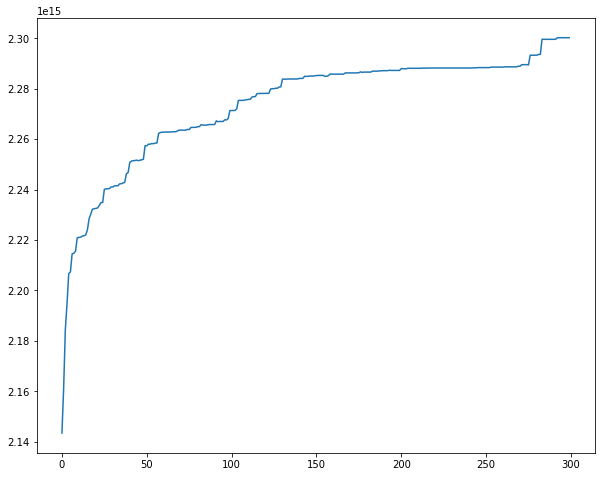

In [4]:
file = 'moead-reduced-pareto-execution-'
folder = 'MOEAD_R3_CA'
hv_1, hv_1_df = plot_hypervolume_convergence(folder, file, 3)

# Convergência do HV em $\mathbb{R}^8$ para MOEAD com agregação de Funções Objetivo

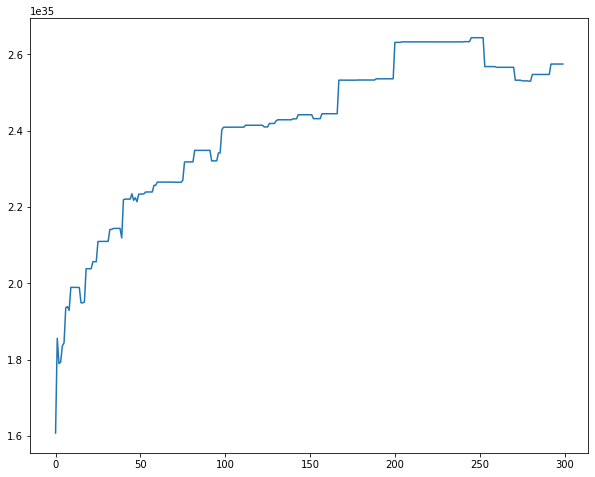

In [5]:
file = 'moead-original-pareto-execution-'
folder = 'MOEAD_R3_CA'
hv_2, hv_2_df = plot_hypervolume_convergence(folder, file, 8)

# Convergência do HV em $\mathbb{R}^3$ para MOEAD sem agregação de Funções Objetivo

- Formulação utilizada
$$F_1 = f_1 \\ F_2 = f_5 \\ F_3 = f_3 $$

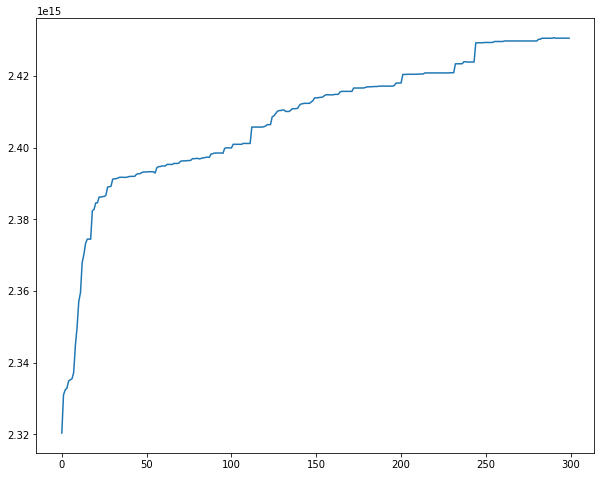

In [6]:
file = 'moead-reduced-pareto-execution-'
folder = 'MOEAD_R3_SA'
hv_3, hv_3_df = plot_hypervolume_convergence(folder, file, 3)

# Convergência do HV em $\mathbb{R}^8$ para MOEAD sem agregação de Funções Objetivo

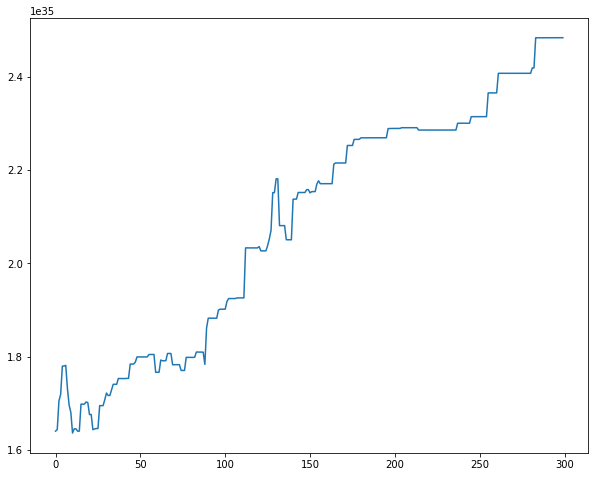

In [7]:
file = 'moead-original-pareto-execution-'
folder = 'MOEAD_R3_SA'
hv_4, hv_4_df = plot_hypervolume_convergence(folder, file, 8)

# Convergência do HV em $\mathbb{R}^3$ para onMOEAD 

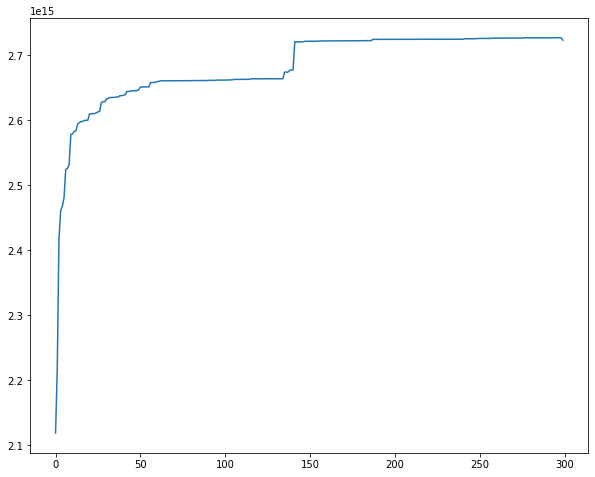

In [8]:
file = 'onmoead-reduced-pareto-execution-'
folder = 'ONMOEAD'
hv_6, hv_6_df = plot_hypervolume_convergence(folder, file, 3)

# Convergência do HV em $\mathbb{R}^8$ para onMOEAD

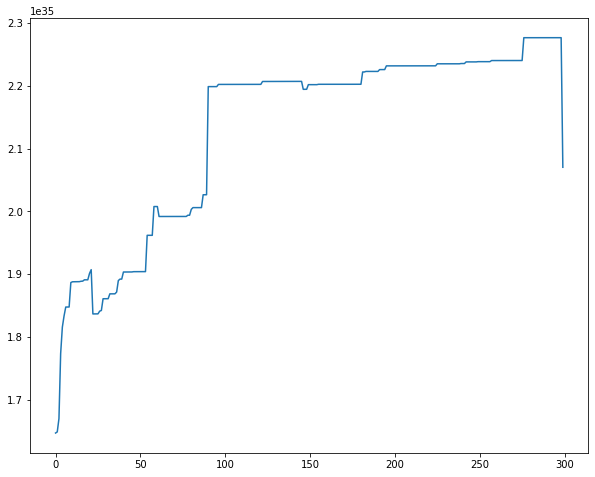

In [9]:
file = 'onmoead-original-pareto-execution-'
folder = 'ONMOEAD'
hv_7, hv_7_df = plot_hypervolume_convergence(folder, file, 8)

# Convergência do HV em $\mathbb{R}^8$ para MOEAD

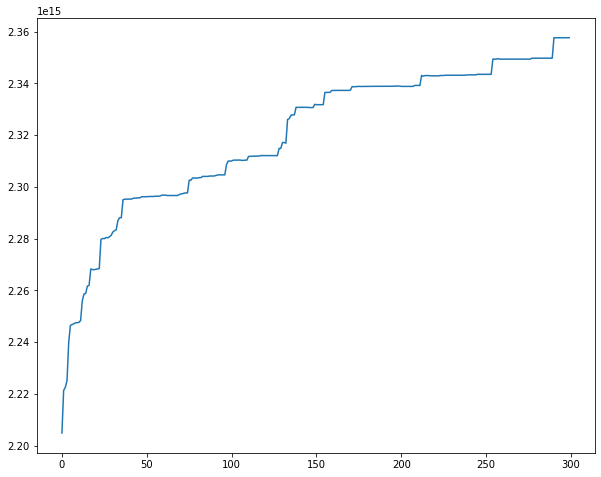

In [10]:
file = 'moead-reduced-pareto-execution-'
folder = 'MOEAD_R8'
hv_8, hv_8_df = plot_hypervolume_convergence_reduced(folder, file, 1)

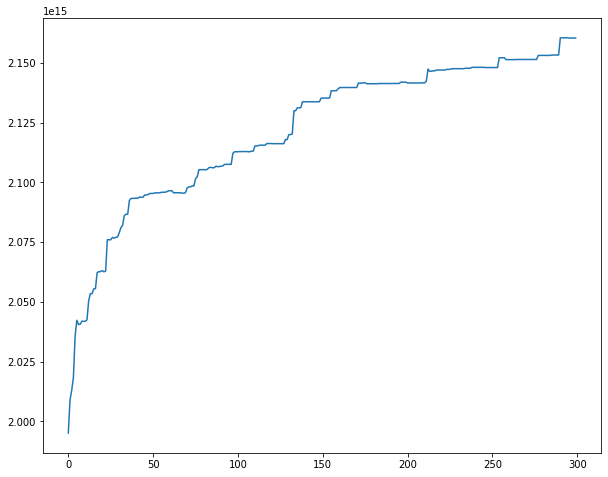

In [11]:
file = 'moead-reduced-pareto-execution-'
folder = 'MOEAD_R8'
hv_9, hv_9_df = plot_hypervolume_convergence_reduced(folder, file, 2)

# Convergências de HV em $\mathbb{R}^8$

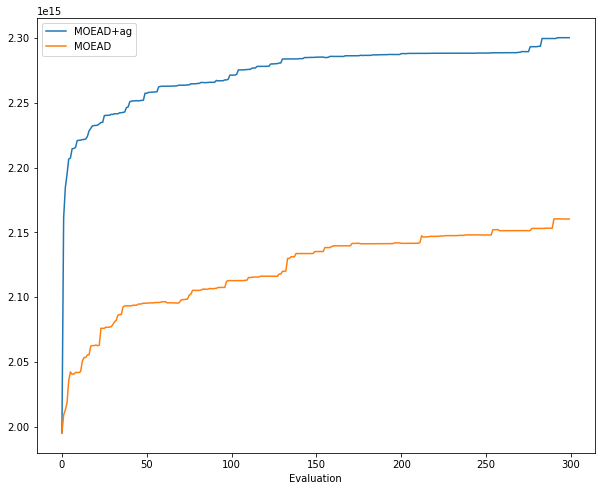

In [12]:
hv_1[0] = 1995165340604690.5
hv_9[0] = 1995165340604690.5
plt.figure(figsize=(10,8))
plt.plot(hv_1, label = "MOEAD+ag")
plt.plot(hv_9, label = "MOEAD")
plt.xlabel('Evaluation')
plt.legend()
plt.show()

In [13]:
hv_3[0]

2320396852847666.0

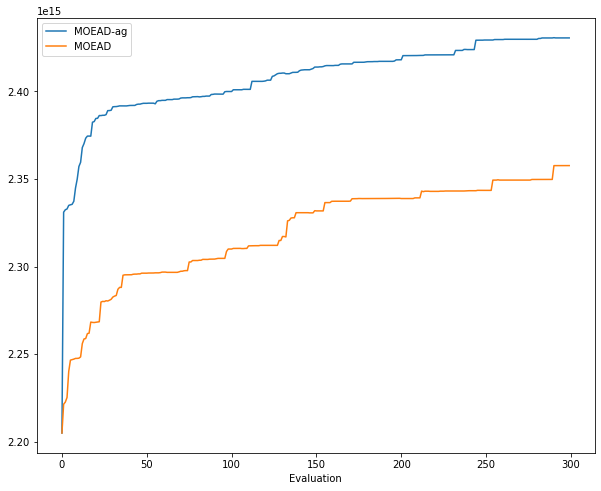

In [14]:
hv_3[0] = hv_8[0]
plt.figure(figsize=(10,8))
plt.plot(hv_3, label = "MOEAD-ag")
plt.plot(hv_8, label = "MOEAD")
plt.xlabel('Evaluation')
plt.legend()
plt.show()

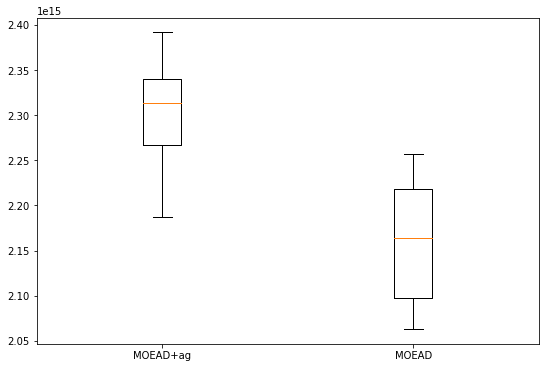

In [15]:
data_to_plot = [hv_1_df.iloc[299:].values.tolist()[0],
                hv_9_df.iloc[299:].values.tolist()[0]]
plt.figure(figsize=(9, 6))
plt.boxplot(data_to_plot, labels=["MOEAD+ag","MOEAD"])
plt.show()

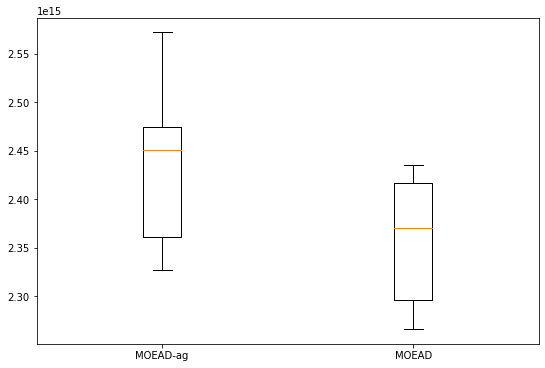

In [16]:
data_to_plot = [hv_3_df.iloc[299:].values.tolist()[0],
                hv_8_df.iloc[299:].values.tolist()[0]]
plt.figure(figsize=(9, 6))
plt.boxplot(data_to_plot, labels=["MOEAD-ag","MOEAD"])
plt.show()

- pegar pareto combinado do moead em r8
- levar pareto para r3 com agregação com todas e escolhendo
- rodar uma dominancia em r3
- plotar os paretos
- moead no R do felipe campelo (moeadr package) google scholar - olhar a atualização do arquivo - como é feito?
- executar jars no cluster

# Set coverage para Paretos combinados

In [128]:
path = '/home/renansantos/Área de Trabalho/Doutorado/PhD_2019_01/PhD_2019_01/Results_2020/MOEAD/'

moead_R3_SA = pd.read_csv(os.path.join(path,'MOEAD_R3_SA','moead-combined_pareto.csv'), header=None)
moead_R3_CA = pd.read_csv(os.path.join(path,'MOEAD_R3_CA','moead-combined_pareto.csv'), header=None)
moead_R8 = pd.read_csv(os.path.join(path,'MOEAD_R8','moead-combined_pareto.csv'), header=None)
onmoead = pd.read_csv(os.path.join(path,'ONMOEAD','onmoead-combined_pareto.csv'), header=None)

moead_R3_SA = moead_R3_SA.drop_duplicates()
moead_R3_CA = moead_R3_CA.drop_duplicates()
moead_R8 = moead_R8.drop_duplicates()
onmoead = onmoead.drop_duplicates()

In [117]:
%%time
set_coverage_metric(moead_R3_SA.values, moead_R8.values)

Returning C(A,B) and C(B,A)
CPU times: user 1.36 s, sys: 3.71 ms, total: 1.37 s
Wall time: 1.37 s


(0.035398230088495575, 0.07692307692307693)

In [118]:
%%time
set_coverage_metric(moead_R3_CA.values, moead_R8.values)

Returning C(A,B) and C(B,A)
CPU times: user 1.81 s, sys: 3.59 ms, total: 1.82 s
Wall time: 1.81 s


(0.038348082595870206, 0.0)

In [129]:
%%time
set_coverage_metric(moead_R3_SA.values, moead_R3_CA.values)

Returning C(A,B) and C(B,A)
CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 222 ms


(0.0, 0.02564102564102564)

In [130]:
%%time
set_coverage_metric(onmoead.values, moead_R8.values)

Returning C(A,B) and C(B,A)
CPU times: user 3.39 s, sys: 0 ns, total: 3.39 s
Wall time: 3.38 s


(0.07669616519174041, 0.020618556701030927)

# Teste de Aleatoriedade

In [134]:
random_test(hv_2_df.iloc[299:], hv_4_df.iloc[299:], 10, False)

H0
Limiar = 4.545673471737927e+34
z = -0.367547152030185
Mean Spread Diff -9.051621776625216e+33


In [135]:
random_test(hv_2_df.iloc[299:], hv_5_df.iloc[299:], 10, False)

H1+
Limiar = 4.467461223283982e+34
z = 5.153830791777887
Mean Spread Diff 1.1804323241906264e+35


In [132]:
random_test(hv_7_df.iloc[299:], hv_4_df.iloc[299:], 10, False)

H0
Limiar = 1.0224484414149157e+35
z = 0.7876339380719625
Mean Spread Diff 4.1375964860008513e+34


In [133]:
random_test(hv_7_df.iloc[299:], hv_2_df.iloc[299:], 10, False)

H0
Limiar = 1.046009414582235e+35
z = 0.9282361694359023
Mean Spread Diff 5.042758663663373e+34


In [136]:
random_test(hv_7_df.iloc[299:], hv_5_df.iloc[299:], 10, False)

H1+
Limiar = 1.0262491015550448e+35
z = 3.2242202761596706
Mean Spread Diff 1.6847081905569637e+35
